In [1]:
import numpy as np
from pandas import Series
import matplotlib.pyplot as plt

In [2]:
def S(L):
  # L x L 크기의 무작위 스핀 격자를 생성하는 함수
  return np.random.choice([-1, 1], size=(L, L))

def initialize(beta):
  # 메트로폴리스 알고리즘에 사용될 확률 초기화
  global prob
  prob = np.zeros(5)
  for i in range(2, 5, 2):
    prob[i] = np.exp(-2*beta*i)  # exp^(-4*beta)와 exp^(-8*beta)를 계산하여 prob 배열에 저장

def single_spin_flip(matrix):
  # 주어진 스핀 매트릭스에서 무작위 한 스핀을 뒤집는 함수
  global N, L
  i, j = np.random.randint(L), np.random.randint(L)
  new_matrix = matrix.copy()
  new_matrix[i, j] *= -1  # (i, j) 위치의 스핀을 뒤집음
  return new_matrix

def energy(spin_matrix):
  # 주어진 스핀 매트릭스의 에너지를 계산하는 함수
  global N, L
  total_energy = 0
  for i in range(L):
    for j in range(L):
      total_energy -= spin_matrix[i, j]*(spin_matrix[(i+1)%L, j]+spin_matrix[i, (j+1)%L])
      # (i, j) 스핀과 그 이웃 스핀들 간의 에너지 기여를 계산
  return total_energy

def accept(E1, E2):
  # 메트로폴리스 기준으로 새로운 상태를 받아들일지 거부할지 결정하는 함수
  if E2 < E1 or np.random.rand() < np.exp(beta * (E1 - E2)):
    return 1  # 새로운 구성을 받아들임
  else:
    return 0  # 새로운 구성을 거부함

def m(matrix):
  # 주어진 스핀 매트릭스의 자화율을 계산하는 함수
  return np.abs(np.sum(matrix))/N

def make_list(beta, n = 10000):
  # 주어진 온도와 반복 횟수에 따라 자화율과 에너지 리스트를 생성하는 함수
  m_list = []
  E_list = []
  SL = S(L)  # 초기 스핀 격자 생성
  for _ in range(n):
    flip_SL = single_spin_flip(SL)  # 무작위 스핀을 하나 뒤집은 새로운 격자 생성
    E_mu = energy(SL)  # 현재 격자의 에너지 계산
    E_nu = energy(flip_SL)  # 뒤집은 격자의 에너지 계산
    if accept(E_mu, E_nu) == 1:
      SL = flip_SL  # 새로운 구성을 받아들임
    m_list.append(m(SL))  # 자화율 리스트에 현재 격자의 자화율 추가
    E_list.append(E_mu)  # 에너지 리스트에 현재 격자의 에너지 추가
  return m_list, E_list

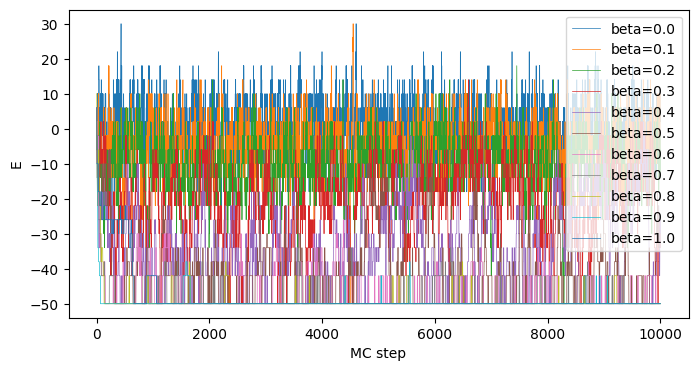

In [ ]:
L = 5
N = L*L
beta_values = np.linspace(0, 1, 11)

results_E = np.zeros(len(beta_values))
results_S_avg = np.zeros(len(beta_values))
errors_E = np.zeros(len(beta_values))
errors_S_avg = np.zeros(len(beta_values))

plt.figure(figsize=(8, 4))

for i, beta in enumerate(beta_values):
  m_list, E_list = make_list(beta)
  plt.plot(E_list, label=f'beta={beta:.1f}', linewidth="0.5")

plt.xlabel('MC step')
plt.ylabel('E')
plt.legend()
plt.show()

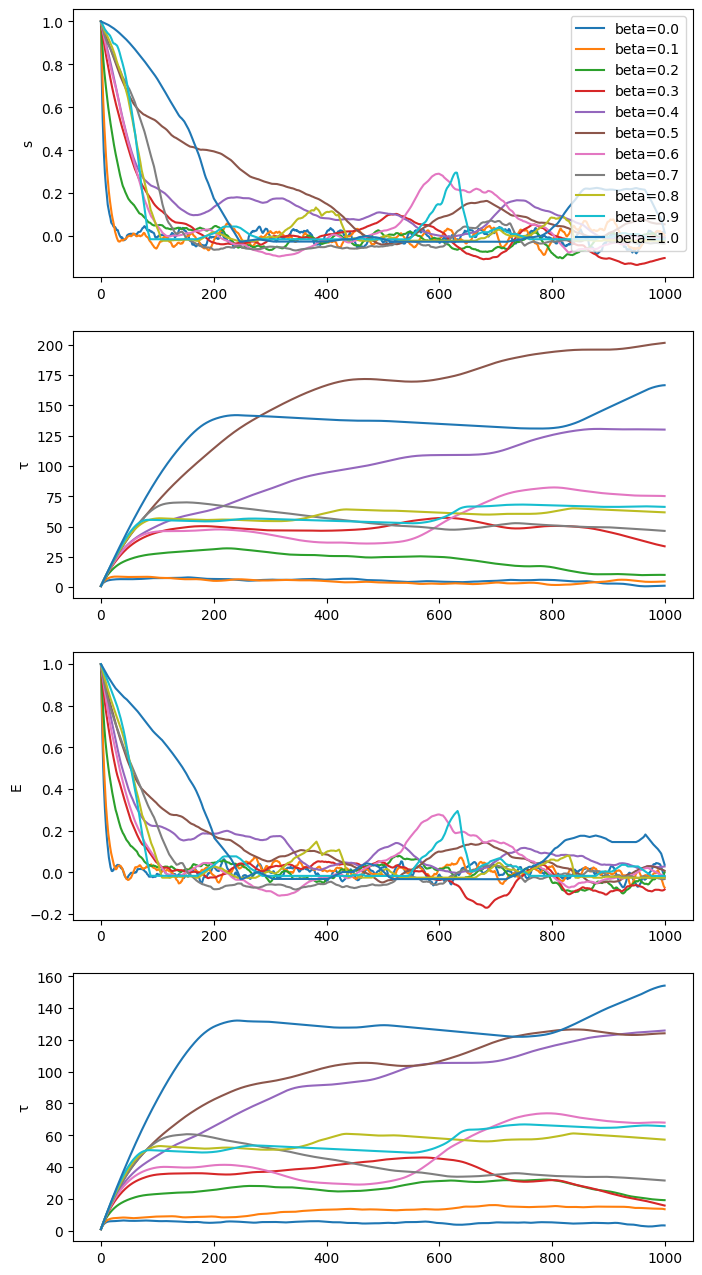

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(8, 16))

for i, beta in enumerate(beta_values):
  initialize(beta)
  s_list, E_list = make_list(beta)
  results_E[i] = np.mean(E_list)
  results_S_avg[i] = np.mean(s_list)

  Slist1 = []
  S1 = Series(s_list)
  tau_list1 = []
  kstart = 0
  krange = 1000
  for k in range(kstart, krange):
    Slist1.append(S1.autocorr(k))
    tau1 = sum(Slist1)
    tau_list1.append(tau1)
  axs[0].plot(Slist1, label=f'beta={beta:.1f}')
  axs[1].plot(tau_list1)

  Slist2 = []
  S2 = Series(E_list)
  tau_list2 = []
  for k in range(kstart, krange):
    Slist2.append(S2.autocorr(k))
    tau2 = sum(Slist2)
    tau_list2.append(tau2)
  axs[2].plot(Slist2)
  axs[3].plot(tau_list2)

  tau_s = tau_list1[-1]
  tau_E = tau_list2[-1]
  vs = 0
  vE = 0
  error_n = krange - kstart
  for l in range(kstart, krange):
    vs += (s_list[l]-tau_s)**2
    vE += (E_list[l]-tau_E)**2
  vs /= error_n
  vE /= error_n

  errors_S_avg[i] = np.sqrt(vs)/np.sqrt(error_n-1)
  errors_E[i] = np.sqrt(vE)/np.sqrt(error_n-1)

axs[0].set_ylabel('s')
axs[1].set_ylabel('τ')
axs[2].set_ylabel('E')
axs[3].set_ylabel('τ')
axs[0].legend()

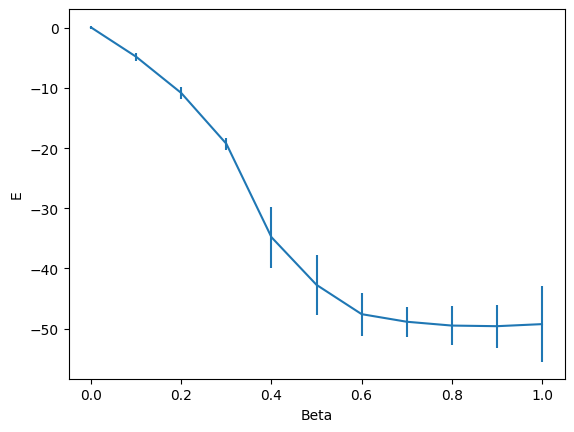

In [ ]:
plt.errorbar(beta_values, results_E, yerr=errors_E, fmt='-')
plt.xlabel('Beta')
plt.ylabel('E')

plt.show()